# Dogs vs Cats – ML Image Classification (Evaluation Focus)

This notebook documents an exploratory ML image classification project prepared collaboratively for a GDG session.

As a first hands-on ML project, the focus was on learning by building, with particular attention to how evaluation choices affect perceived model performance and generalisation.


## 1. Problem Context

The goal of this project was to build and experiment with an ML image classification model to distinguish between dog and cat images.

Rather than optimising for maximum accuracy, this project prioritised understanding the end-to-end workflow and the impact of evaluation decisions during model development.


In [ ]:
# Install and import libraries
!pip install -q opendatasets
import opendatasets as od
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Download dataset
od.download("https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat")

# Set paths
data_dir = '/content/dog-vs-cat/animals'

# Clean corrupted images
num_skipped = 0
for folder_name in ("dog", "cat"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            img = Image.open(fpath)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Deleting corrupted image: {fpath}")
            os.remove(fpath)
            num_skipped += 1

print(f"Deleted {num_skipped} corrupted images")

# Check dataset
for folder in ["dog", "cat"]:
    count = len(os.listdir(os.path.join(data_dir, folder)))
    print(f"{folder}: {count} images")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sukhmanpb26
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/anthonytherrien/dog-vs-cat


100%|██████████| 360M/360M [00:00<00:00, 646MB/s]

Deleted 0 corrupted images
dog: 500 images
cat: 500 images


## Train, Validation, and Test Strategy

The dataset was split into training, validation, and test subsets.
The test set was kept completely untouched until final evaluation.


In [ ]:

# ============================================
# PREPARE DATASETS (80% train, 10% val, 10% test)
# ============================================
batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Split validation set into val + test
val_batches = tf.data.experimental.cardinality(val_ds)
test_size = val_batches // 2

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)

print("\n" + "="*50)
print("DATASET SPLIT")
print("="*50)
print(f"TRAIN batches: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"VAL batches: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"TEST batches: {tf.data.experimental.cardinality(test_ds).numpy()}")

# Get class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")

# Optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.

DATASET SPLIT
TRAIN batches: 25
VAL batches: 4
TEST batches: 3
Classes: ['cat', 'dog']


## Visualising Sample Training Images

A small batch of training images was visualised to confirm that the data was loaded correctly and that labels aligned with the corresponding images.


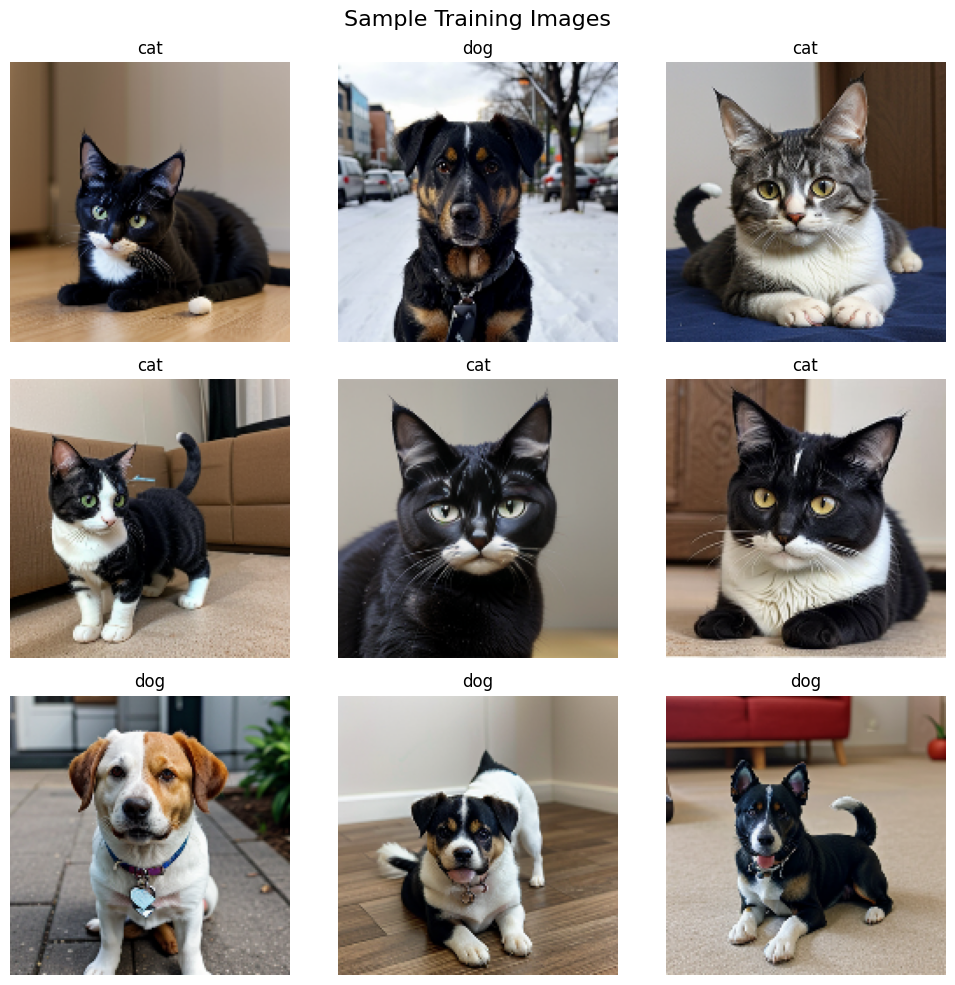

In [ ]:
# ============================================
# VISUALIZE SAMPLE IMAGES
# ============================================
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images", fontsize=16)
plt.tight_layout()
plt.show()


## Model Architecture

A transfer learning approach was used with MobileNetV2 pre-trained on ImageNet as the feature extractor.

The base model was frozen, and a lightweight classification head was added to focus on learning task-specific features while reducing overfitting and training time.


In [ ]:
# ============================================
# BUILD MODEL
# ============================================
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n" + "="*50)
print("MODEL ARCHITECTURE")
print("="*50)
print(model.summary())


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

MODEL ARCHITECTURE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


## Training

The model was trained for a fixed number of epochs using the training set, with validation data used to monitor performance during training.

Validation metrics were observed during training but not treated as a final measure of generalisation.


In [ ]:
# ============================================
# TRAIN MODEL
# ============================================
print("\n" + "="*50)
print("STARTING TRAINING")
print("="*50)
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

print("\n Training complete!")



STARTING TRAINING
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 814ms/step - accuracy: 0.5543 - loss: 0.7615 - val_accuracy: 0.7981 - val_loss: 0.4030
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.8075 - loss: 0.4263 - val_accuracy: 0.8942 - val_loss: 0.2723
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8972 - loss: 0.2957 - val_accuracy: 0.9327 - val_loss: 0.2116
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8996 - loss: 0.2570 - val_accuracy: 0.9615 - val_loss: 0.1736
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9146 - loss: 0.2170 - val_accuracy: 0.9712 - val_loss: 0.1504
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9430 - loss: 0.1789 - val_accuracy: 0.9712 - val_loss: 0.1344
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9416 - loss: 0.1665 - val_accuracy: 0.9712 - val_loss: 0.1235
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9507 - loss: 0.1549 - val

## Training History

Training and validation accuracy and loss were plotted across epochs to observe learning behaviour and potential signs of overfitting during training.


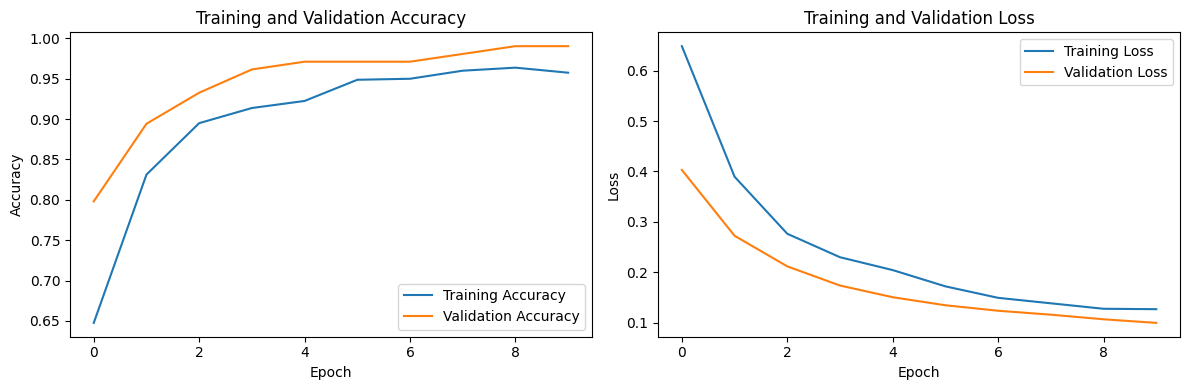

In [ ]:
# ============================================
# PLOT TRAINING HISTORY
# ============================================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


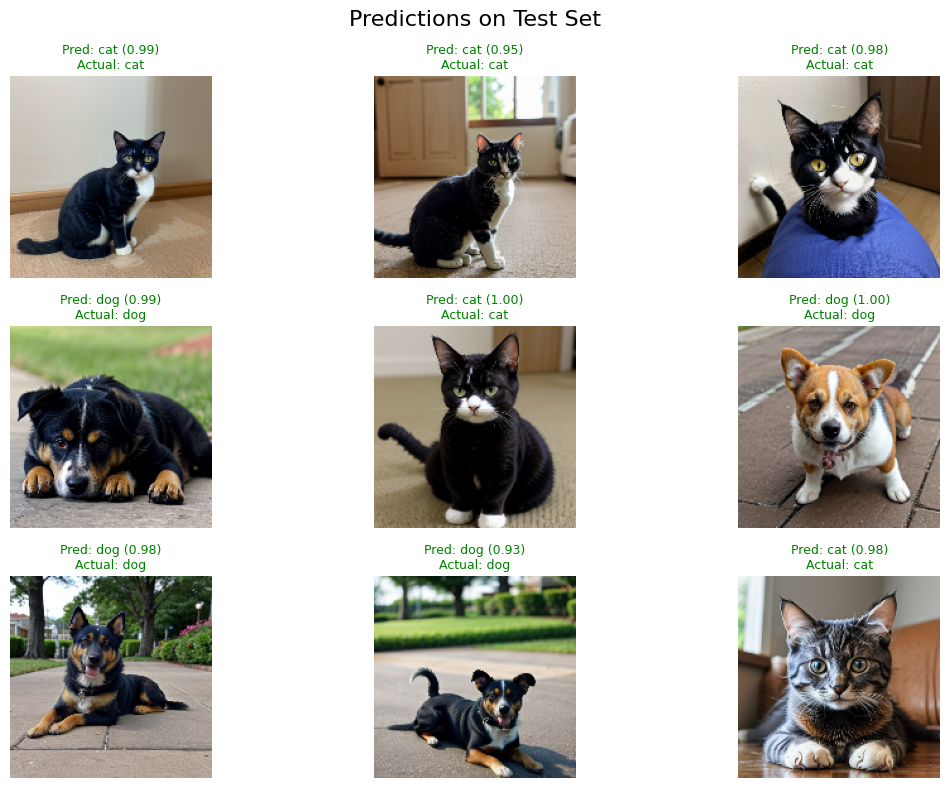

In [ ]:
# ============================================
# VISUALIZE PREDICTIONS ON TEST SET
# ============================================
plt.figure(figsize=(12, 8))
for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        # Interpret prediction
        predicted_class = "dog" if predictions[i] > 0.5 else "cat"
        actual_class = class_names[labels[i]]
        confidence = predictions[i][0] if predictions[i] > 0.5 else 1 - predictions[i][0]

        # Color code: green if correct, red if wrong
        color = "green" if predicted_class == actual_class else "red"
        plt.title(f"Pred: {predicted_class} ({confidence:.2f})\nActual: {actual_class}",
                 color=color, fontsize=9)
        plt.axis("off")
plt.suptitle("Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()

## Evaluation

Final model performance was assessed using a strictly held-out test set that was not used during training or validation.

Although the test accuracy is high, it is interpreted cautiously, as validation metrics had already influenced training decisions earlier in the workflow.


In [ ]:
# ============================================
# FINAL EVALUATION ON TEST SET
# ============================================
print("\n" + "="*50)
print("FINAL MODEL PERFORMANCE (TEST SET)")
print("="*50)

loss, accuracy = model.evaluate(test_ds)
print(f"\n Final Test Accuracy: {accuracy*100:.2f}%")
print(f" Final Test Loss: {loss:.4f}")


FINAL MODEL PERFORMANCE (TEST SET)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9727 - loss: 0.1535

 Final Test Accuracy: 96.88%
 Final Test Loss: 0.1526


## Predictions on the Test Set

Sample predictions were visualised on the held-out test set to qualitatively assess model behaviour on unseen data and to inspect correct and incorrect classifications.


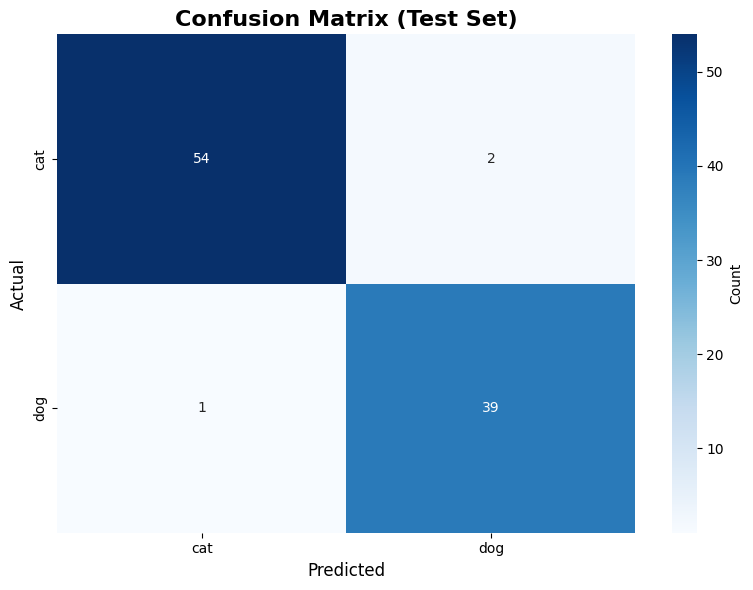


DETAILED CLASSIFICATION REPORT (TEST SET)
              precision    recall  f1-score   support

         cat       0.98      0.96      0.97        56
         dog       0.95      0.97      0.96        40

    accuracy                           0.97        96
   macro avg       0.97      0.97      0.97        96
weighted avg       0.97      0.97      0.97        96



In [ ]:
# ============================================
# CONFUSION MATRIX & CLASSIFICATION REPORT
# ============================================
# Get all predictions and true labels from test set

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Print detailed metrics
print("\n" + "="*50)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))


## Model Saving

The trained model was saved locally for future use and experimentation.


In [ ]:
# ============================================
# SAVE MODEL
# ============================================
model.save('cat_dog_classifier.keras')
print("\n Model saved as 'cat_dog_classifier.keras'")

# Download model
from google.colab import files
files.download('cat_dog_classifier.keras')
print("Model downloaded to your computer")


 Model saved as 'cat_dog_classifier.keras'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded to your computer


## Optional: Interactive Model Demo

This section provides a simple interactive way to load the trained model and apply it to arbitrary images.

It was used to qualitatively inspect model behaviour on unseen inputs and is not part of the training or formal evaluation pipeline.


Please upload your cat_dog_classifier.keras file:


Saving cat_dog_classifier.keras to cat_dog_classifier (5).keras

Loading model: cat_dog_classifier (5).keras

Now upload image(s) to classify:


Saving (Upload-from-mobile-1764321020)IMG_7685.jpeg to (Upload-from-mobile-1764321020)IMG_7685.jpeg


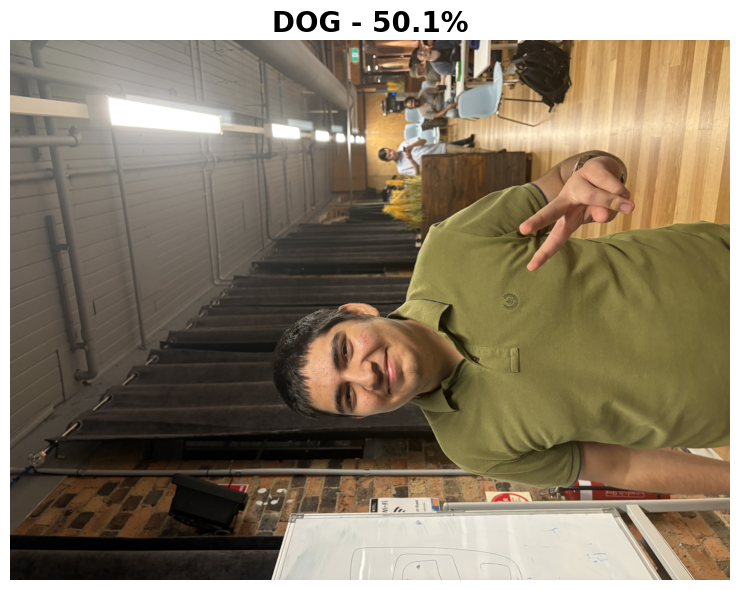

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from PIL import Image

def quick_test():
    """
    Ultra-fast testing - minimal output
    """
    # Upload the model file from your computer
    print("Please upload your cat_dog_classifier.keras file:")
    uploaded_model = files.upload()

    # Get the uploaded model filename
    model_filename = list(uploaded_model.keys())[0]

    # Load the model
    print(f"\nLoading model: {model_filename}")
    model = load_model(model_filename)

    # Now upload test images
    print("\nNow upload image(s) to classify:")
    uploaded = files.upload()

    for fname in uploaded.keys():
        img = load_img(fname, target_size=(160, 160))
        img_array = np.expand_dims(img_to_array(img), axis=0)
        pred = model.predict(img_array, verbose=0)[0][0]

        result = "DOG" if pred > 0.5 else "CAT"
        conf = (pred if pred > 0.5 else 1-pred) * 100

        # Quick display
        plt.figure(figsize=(8, 6))
        plt.imshow(Image.open(fname))
        plt.title(f"{result} - {conf:.1f}%", fontsize=20, fontweight='bold')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

quick_test()